# Data Analysis - Income and Houshold Size

Steps:

1 - Find percent change on cantonal or regional level
    Are there trends? Form groups of small communes vs big communes
    
2 - Extrapolate Income on communal level 2007 - 2016

3 - Analyse correlation(pearson R) between HH-size and Income on communal level

## Steps from Workbook DataAnalysis

In [1]:
%matplotlib inline
import os
import pandas as pd
import json
import folium
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import itertools

In [2]:
data_folder = './data/wrangled_data/'
data_incomes = './data/Incomes.csv'
map_folder = './data/map_data/'

In [3]:
# the cleaned and wrangled data from the notebook "Data Wrangling" is imported and numerous arrays are created
array_names = []

incomes = pd.read_csv(data_incomes)

for i in os.listdir(data_folder):
    globals()['%s' %i[:-4]] = pd.read_csv(data_folder + str(i))
    array_names.append(i[:-4])
    
#contains the list of all availble arrays
pd.DataFrame(array_names, columns=['Array Name']).sort_values(['Array Name']).head()

,Array Name
24,demographics2010
4,demographics2011
14,demographics2012
9,demographics2013
60,demographics2014


### New

### Extrapolation of Income Table

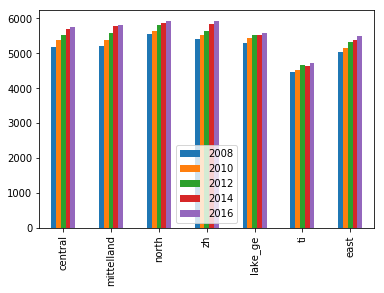

,2008,2010,2012,2014,2016
central,5185,5392,5520,5684,5756
mittelland,5200,5373,5583,5773,5803
north,5560,5647,5814,5856,5932
zh,5415,5513,5651,5846,5921
lake_ge,5284,5425,5517,5515,5583
ti,4460,4514,4664,4640,4722
east,5050,5143,5308,5367,5482


In [4]:
#create table for median incomes for all regions and years available
regions = ['central', 'mittelland', 'north', 'zh', 'lake_ge', 'ti', 'east']
wages_years = ['2008', '2010', '2012', '2014', '2016']

med_income_region = pd.DataFrame(columns=wages_years, index=regions)

for region in regions:
    for year in wages_years:
        str = region+year
        med_income_region.loc[region,year] = float(globals()['wages%s' %year+region][' Median'][1])

med_income_region.plot(kind='bar')
plt.show()

med_income_region

In [5]:
#create income dataframe with entries for 2008 as in 2007
cantons_path = './data/cantons.csv'
cantons = pd.read_csv(cantons_path)

header = ['Name', 'canton', '2008', '2010', '2012', '2014', '2016']
med_incomes = pd.DataFrame(columns=header, index=incomes.ID)
med_incomes[['Name','canton','2008']]=incomes[['NAME', 'KT', 'MEDREV']]
med_incomes= med_incomes.merge(cantons,left_on='canton', right_on='Kantonsnr').drop(columns=['canton'])

In [6]:
#extrapolate linearly from 2008(=2007) to dates
for ind in range(0,med_incomes.shape[0]): 
    for year in wages_years:
        region= med_incomes.loc[ind,'region']
        med_incomes.loc[ind,year] = med_incomes.loc[ind,'2008']*med_income_region.loc[region,year]/med_income_region.loc[region,'2008']   
#med_incomes.set_index('Name')

## Preparation of HHsizes and Merge for Correlation Analysis

Due to the fusion of communes, every year the number of communes decreases. However, for a correlation analysis the number of communes compared must be equal. We therefore can only compare the communes we have data in common.

In [7]:
def cleanhhsizes(hh_sizes):
    '''
    Removes unneccessary columns and cleans commune names
    '''
    hh_sizes=hh_sizes.drop(columns=['Unnamed: 0','not plausible hh'])
    hh_sizes['Commune']=hh_sizes['Commune'].str.lstrip(' 0123456789')
    #hh_sizes2014.set_index('Commune')
    return hh_sizes


In [8]:
#run functions on datasets for all years
hh_sizes2010 = cleanhhsizes(hh_sizes2010)
hh_sizes2012 = cleanhhsizes(hh_sizes2012)
hh_sizes2014 = cleanhhsizes(hh_sizes2014)
hh_sizes2016 = cleanhhsizes(hh_sizes2016)

#TO DO: write above in forloop for globals()   

In [10]:
#### procedure for year 2014, repeat for all availables

#merge on communes available in both datasets for all years available

merged = pd.merge(left=hh_sizes2014, right=med_incomes[['Name','2014']], how='inner', left_on='Commune', right_on='Name').drop(columns='Name')
merged

,Commune,Total,1-person households,2-person households,3-person households,4-person households,5-person households,6-person or larger households,2014
0,Affoltern am Albis,11316,1589,3314,1896,2452,1185,880,56.1605
1,Bonstetten,5272,609,1556,924,1548,490,145,67.8833
2,Hausen am Albis,3426,385,1032,588,920,330,171,60.4385
3,Hedingen,3635,405,1062,612,1072,355,129,63.5319
4,Kappel am Albis,1008,123,276,147,268,145,49,61.3083
5,Knonau,2029,207,554,393,548,230,97,58.8862
6,Maschwanden,663,80,162,96,212,80,33,54.8358
7,Mettmenstetten,4400,445,1318,780,1296,455,106,62.551
8,Obfelden,4897,537,1386,882,1296,590,206,58.0521
9,Ottenbach,2519,265,876,411,684,220,63,61.897


2261 ouf of 2726 communes could be merged. We regard this as sufficient to calculate regression.

In [11]:
#calculate the share of hh sizes for every commune
merged.iloc[:,2:8] = merged.iloc[:,2:8].div(merged['Total'].values,axis=0)

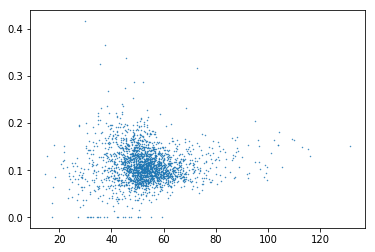

In [12]:
plt.scatter(data=merged, x='2014', y='5-person households', s=0.2 )
plt.show()

In [19]:
stats.pearsonr(x=merged['2014'],y=merged['1-person households'])

(-0.3544289874842878, 6.676103141945665e-68)

In [20]:
def LMplot (x,y):
    '''
    Function fits linear regression model and calculates corresponding statistics.
    Data and regression line is then plotted
     :input: pandas dataframe with columns named 'SelfEmployed' and 'IncomePerCap'
     :output: print statistics and plot linear regression
     :return: -
     '''

    #calculate linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    #plot model and existing data
    plt.figure(figsize=(18, 10))
    plt.plot(x, y, 'o',ms=2, label='original data')
    plt.plot(x, intercept + slope*x, 'r', label='fitted line')
    plt.legend()
    plt.xlabel('% Self-employed')
    plt.ylabel('Income per Capita [$]')
    plt.show()

    #print statistics
    print('''The formula for the fitted linear Model is: y = %f + %f * x \n \n r-value = %f
 p-value = %f \n Standard_error: %f''' % (intercept, slope,r_value, p_value, std_err)) 

In [21]:
LMplot(x=merged['2014'],y=merged['1-person households'])

AttributeError: 'float' object has no attribute 'shape'

In [ ]:
def hhcorr (hhsize):
    hh_sizes.iloc[:,3:9] = hh_sizes2010.iloc[:,3:9].div(hh_sizes2010['Total'].values,axis=0)

In [ ]:
hh_sizes2010=hh_sizes2010.dropna()
hh_sizes2010=hh_sizes2010[hh_sizes2010.Commune.str[0:4].str.isdigit()]

To Do:
- clean hh_sizes (better header,remove ()), change in datawrangling
- divide hhsizes / sum -> hh_percentage
- plot and take correlation between hhpercentage for different years and hh-sizes
